# Exposure to change in heatwave occurrance 

- INFANTS and over 65


> Now using the new heatwave definitions that depend on both the tmin and tmax percentiles

---

> Using upscaled population data for pre-2000, this is an approximation! Needs to be shown as such on the graphs 

---

> Using VERY ROUGH ESTIMATE of yearly newborn pop, this is EVEN MORE ROUGH for the pre-2000 data

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

import xarray as xr
import matplotlib.pyplot as plt

from cartopy import crs as ccrs
from scipy import stats
import os
import sys


project_path = os.path.abspath(os.path.join('..', '..'))
if project_path not in sys.path:
    sys.path.insert(0, project_path)

from source.config import DATA_SRC, POP_DATA_SRC, WEATHER_SRC

In [2]:
# Figure settings
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = (5,2.5)
plt.rcParams['figure.titlesize'] = 'medium'
plt.rcParams['axes.titlesize'] = 'medium'
plt.rcParams['savefig.bbox'] = 'tight'

In [3]:
MAP_PROJECTION = ccrs.EckertIII()

In [4]:
MAX_YEAR = 2023

REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = DATA_SRC / 'lancet/results/results_2024/worldpop_hw_exposure'



In [18]:
MIN_YEAR = 1980



# Load Data

## Load population and demographic data

In [5]:
POP_FOLDER = POP_DATA_SRC / 'lancet'/ 'populations'/ 'hybrid_2024'
population_infants_worldpop = xr.open_dataset(POP_DATA_SRC / 'hybrid_2024' /f'worldpop_infants_1950_2023_era5_compatible.nc').sel(year=slice(1980,2023))
population_elderly_worldpop = xr.open_dataset(POP_DATA_SRC / 'hybrid_2024' / f'worldpop_elderly_1950_2023_era5_compatible.nc').sel(year=slice(1980,2023))

population_worldpop = xr.concat([population_infants_worldpop.rename({"infants":"pop"}), population_elderly_worldpop.rename({"elderly":"pop"})], 
                      dim=pd.Index([0, 65], name='age_band_lower_bound'))

## Load heatwave lengths and counts data

> TODO would like to split this up into yearly files so I only need to re-do one year at a time...

In [6]:
HEATWAVE_FOLDER = DATA_SRC / 'lancet/results/results_2024'

heatwave_metrics_files = sorted((HEATWAVE_FOLDER / 'heatwave_days_era5').glob('*.nc'))
heatwave_metrics = xr.open_mfdataset(heatwave_metrics_files, combine='by_coords')

### Calculate the difference from the mean number of days and number of events

> NOTE: we do a sort of double-difference in this case, since we first define heatwaves based on a historical distribution (99th percentile) then we again calculate the change. Question is open as to whether it's also critical to use the same period for calculating the percentile and calculating the reference period. Also a question whether we should compare the change in exposures rather than the change in heatwaves. The problem (or maybe it's a benefit??) is that you also mix in changes in total population and demographics


In [7]:
heatwaves_metrics_reference = heatwave_metrics.sel(year=slice(REFERENCE_YEAR_START, REFERENCE_YEAR_END)).mean(dim='year')
heatwave_metrics_delta = heatwave_metrics - heatwaves_metrics_reference

In [8]:
heatwave_metrics_delta

<xarray.Dataset>
Dimensions:         (year: 44, latitude: 721, longitude: 1440)
Coordinates:
  * year            (year) int64 1980 1981 1982 1983 ... 2020 2021 2022 2023
  * latitude        (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude       (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    heatwaves_days  (year, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

## Calculate some utility data

In [9]:
# Get the grid weighting factor from the latitude
cos_lat = np.cos(np.radians(heatwave_metrics.latitude))
# Get the total population for normalising
total_pop_over_65 = population_elderly_worldpop.sum(dim=['latitude', 'longitude'], skipna=True)

# Calculate total exposures and save for all metrics

Because the calculation is the same for all metrics, we can calculated it once on the dataset and save

In [16]:
heatwave_metrics_delta

<xarray.Dataset>
Dimensions:         (year: 44, latitude: 721, longitude: 1440)
Coordinates:
  * year            (year) int64 1980 1981 1982 1983 ... 2020 2021 2022 2023
  * latitude        (latitude) float64 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude       (longitude) float64 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
Data variables:
    heatwaves_days  (year, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

In [10]:
population_elderly_worldpop = population_elderly_worldpop.sortby('latitude', ascending=False)

In [41]:
exposures_over65 = heatwave_metrics_delta['heatwaves_days'].transpose('year','latitude','longitude') * population_elderly_worldpop.transpose('year','latitude','longitude')['elderly']

exposures_over65 = exposures_over65.drop('age_band_lower_bound')

In [42]:
exposures_over65 = exposures_over65.rename("heatwaves_days")


In [43]:
exposures_over65

<xarray.DataArray 'heatwaves_days' (year: 44, latitude: 721, longitude: 1440)>
dask.array<mul, shape=(44, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>
Coordinates:
  * year       (year) int64 1980 1981 1982 1983 1984 ... 2020 2021 2022 2023
  * latitude   (latitude) float64 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8

In [45]:
RESULTS_FOLDER / f'heatwave_exposure_change_over65_multi_threshold_{MIN_YEAR}-{MAX_YEAR}_worldpop.nc'

PosixPath('/nfs/n2o/wcr/szelie/lancet/results/results_2024/worldpop_hw_exposure/heatwave_exposure_change_over65_multi_threshold_1980-2023_worldpop.nc')

In [44]:
exposures_over65.to_netcdf(RESULTS_FOLDER / f'heatwave_exposure_change_over65_multi_threshold_{MIN_YEAR}-{MAX_YEAR}_worldpop.nc')

In [22]:
exposures_infants = heatwave_metrics_delta['heatwaves_days'].transpose('year','latitude','longitude')  * population_infants_worldpop.transpose('year','latitude','longitude')['infants']

exposures_infants = exposures_infants.drop('age_band_lower_bound')
exposures_infants = exposures_infants.rename("heatwaves_days")


In [24]:
exposures_infants.to_netcdf(RESULTS_FOLDER / f'heatwave_exposure_change_infants_multi_threshold_{MIN_YEAR}-{MAX_YEAR}_worldpop.nc')

## Total Exposure to change in  to heatwaves

Calculate exposure changes in terms of difference aspects of heatwaves - frequency, length, load. 


In [25]:
total_exposures_over65 = exposures_over65.sum(dim=['latitude', 'longitude']).to_dataframe()

total_exposures_infants = exposures_infants.sum(dim=['latitude', 'longitude']).to_dataframe()

In [26]:
total_exposures_over65.to_csv(RESULTS_FOLDER / 'heatwave_exposure_change_totals_over65_worldpop.csv')

In [27]:
total_exposures_infants.to_csv(RESULTS_FOLDER / 'heatwave_exposure_change_totals_infants_worldpop.csv')

# Weighted mean change

In [28]:
weighted_mean_over65 = ((exposures_over65 / population_elderly_worldpop.sum(dim=['latitude', 'longitude']))
                        .where(~np.isnan(population_elderly_worldpop))
                          .sum(dim=['latitude', 'longitude'],
                               skipna=True).to_dataframe()).drop('age_band_lower_bound', axis=1)

In [29]:
weighted_mean_infants = ((exposures_infants / population_infants_worldpop.sum(dim=['latitude', 'longitude']))
                         .where(~np.isnan(population_infants_worldpop))
                          .sum(dim=['latitude', 'longitude'],
                               skipna=True).to_dataframe()
                        .drop('age_band_lower_bound', axis=1))

In [30]:
weighted_mean_over65.to_csv(RESULTS_FOLDER / 'heatwave_days_change_weighted_over65_worldpop.csv')
weighted_mean_infants.to_csv(RESULTS_FOLDER / 'heatwave_days_change_weighted_infants_worldpop.csv')

#### Directly save the weighted vs overall

In [31]:
heatwave_metrics_delta_mean = (
    (heatwave_metrics_delta  * cos_lat)
    .where(~np.isnan(population_elderly_worldpop.max(dim='year')))
    .mean(dim=['latitude', 'longitude'],
            skipna=True)
    .to_dataframe()
    .drop('age_band_lower_bound', axis=1))

In [32]:
(heatwave_metrics_delta  * cos_lat)['heatwaves_days'].data

dask.array<mul, shape=(44, 721, 1440), dtype=float64, chunksize=(1, 721, 1440), chunktype=numpy.ndarray>

In [33]:
(heatwave_metrics_delta  * cos_lat)['heatwaves_days'].where(~np.isnan(population_elderly_worldpop.max(dim='year')))

<xarray.Dataset>
Dimensions:               (year: 44, latitude: 721, longitude: 1440)
Coordinates:
  * year                  (year) int64 1980 1981 1982 1983 ... 2021 2022 2023
  * latitude              (latitude) float64 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude             (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
    age_band_lower_bound  int64 ...
Data variables:
    elderly               (year, latitude, longitude) float64 dask.array<chunksize=(1, 721, 1440), meta=np.ndarray>

In [34]:
heatwave_metrics_delta_mean = ((heatwave_metrics_delta['heatwaves_days']  * cos_lat)
    .where(~np.isnan(population_elderly_worldpop.max(dim='year')))
    .mean(dim=['latitude', 'longitude'],
            skipna=True)
    .to_dataframe()
    .drop('age_band_lower_bound', axis=1))

In [86]:
population_elderly_worldpop.max(dim='year')

<xarray.Dataset>
Dimensions:               (latitude: 721, longitude: 1440)
Coordinates:
  * latitude              (latitude) float64 90.0 89.75 89.5 ... -89.75 -90.0
  * longitude             (longitude) float64 0.0 0.25 0.5 ... 359.2 359.5 359.8
    age_band_lower_bound  int64 ...
Data variables:
    elderly               (latitude, longitude) float32 0.0 0.0 0.0 ... 0.0 0.0

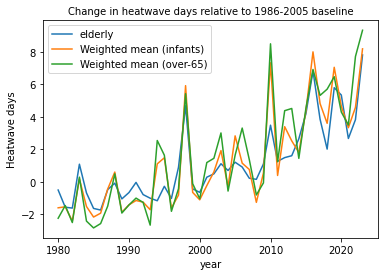

In [35]:
f, ax = plt.subplots(1,1)

heatwave_metrics_delta_mean.plot(ax=ax, label='Global mean (land)')

weighted_mean_infants.infants.plot(ax=ax, label='Weighted mean (infants)')
weighted_mean_over65.elderly.plot(ax=ax, label='Weighted mean (over-65)')
ax.legend()
ax.set(
    ylabel='Heatwave days',
    title='Change in heatwave days relative to 1986-2005 baseline'
)
f.savefig(RESULTS_FOLDER / 'weighted heatwave change comparison worldpop.png', dpi=300)
f.savefig(RESULTS_FOLDER / 'weighted heatwave change comparison worldpop.pdf')

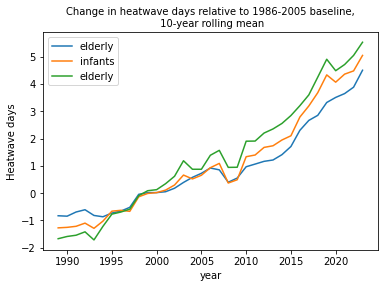

In [36]:
f, ax = plt.subplots(1,1)
n = 10
heatwave_metrics_delta_mean.rolling(n).mean().plot(ax=ax, label='Global mean (land)')

weighted_mean_infants.rolling(n).mean().plot(ax=ax, label='Weighted mean (infants)')
weighted_mean_over65.rolling(n).mean().plot(ax=ax, label='Weighted mean (over-65)')
ax.legend()
ax.set(
    ylabel='Heatwave days',
    title=f'Change in heatwave days relative to 1986-2005 baseline,\n {n}-year rolling mean'
)
f.savefig(RESULTS_FOLDER / 'weighted rolling heatwave change comparison worldpop.png', dpi=300)
f.savefig(RESULTS_FOLDER / 'weighted rolling heatwave change comparison worldpop.pdf')

In [104]:
heatwave_metrics_delta_mean.rolling(n).mean()

,elderly
year,
1980,NaN
1981,NaN
1982,NaN
1983,NaN
1984,NaN
1985,NaN
1986,NaN
1987,NaN
1988,NaN


In [37]:
n=10
rolling_stats = pd.DataFrame({
    'heatwave_days_change_land': heatwave_metrics_delta_mean.rolling(n).mean()['elderly'],
    'heatwave_days_change_infants': weighted_mean_infants.rolling(n).mean()['infants'],
    'heatwave_days_change_over65': weighted_mean_over65.rolling(n).mean()['elderly']}).dropna()

In [38]:
rolling_stats.to_csv(RESULTS_FOLDER / 'heatwave_days_change_10_year_rolling_mean_worldpop.csv')

<AxesSubplot:xlabel='year'>

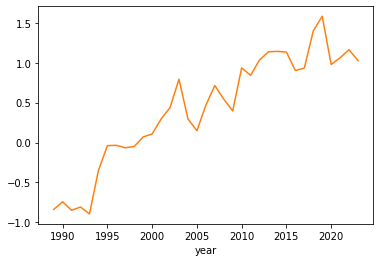

In [ ]:
(weighted_mean_infants - heatwave_metrics_delta_mean).rolling(n).mean()['infants'].plot()

(weighted_mean_over65 - heatwave_metrics_delta_mean).rolling(n).mean()['elderly'].plot()